In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# import libraries
import pandas as pd
import geopandas as gpd 

import json 

from shapely.geometry import LineString # sirve para hacer geometrias

from traclus import traclus as tr
from matplotlib import pyplot as plt
import numpy as np
import ast

In [13]:
# para que los graficos se vean en el notebook
%matplotlib inline 

In [14]:
# Variables globales
latitud = 41.155
longitud = -8.63
zoom = 13
nrows = 1000
# Ruta del archivo CSV
filename = "../train_data/taxis_trajectory/train.csv"

## Cargar archivos de datos

In [15]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar polilíneas vacías o con un solo punto
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None

    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    
    return gdf


In [16]:
# Cargar y simplificar datos (4:16 min 1.7M de filas)
gdf = load_and_simplify_data(filename, nrows)
gdf.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,geometry
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","LINESTRING (-8.61864 41.14141, -8.63275 41.146..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","LINESTRING (-8.63985 41.15983, -8.67085 41.165..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","LINESTRING (-8.61296 41.14036, -8.61421 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","LINESTRING (-8.57468 41.15195, -8.58074 41.145..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","LINESTRING (-8.64599 41.18049, -8.64680 41.178..."


In [18]:
trajectories = []

for polyline in gdf['POLYLINE']:
    # Comprobar si la polilínea es una cadena de texto
    if isinstance(polyline, str):
        try:
            polyline = ast.literal_eval(polyline)
        except ValueError as e:
            print("Error al convertir en lista:", e)
            continue

    trajectory = np.array(polyline, dtype=float)

    trajectories.append(trajectory)

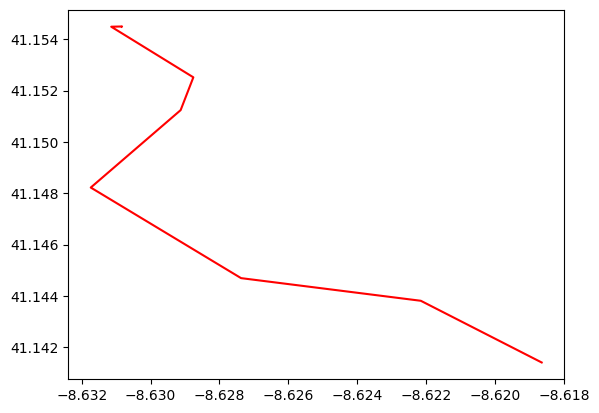

In [24]:
partitions = tr.partition(trajectories[0])
plt.plot(partitions[:, 0], partitions[:, 1], 'r')

plt.show()  

In [25]:
all_trajectories = []

for trajectory in trajectories:
    # Comprobamos que la trayectoria sea un array de numpy o una lista de listas
    if isinstance(trajectory, np.ndarray) or (isinstance(trajectory, list) and all(isinstance(point, list) for point in trajectory)):
        # Simplificamos la trayectoria
        sampled_trajectory = tr.sub_sample_trajectory(trajectory, sample_n=10)
        all_trajectories.append(sampled_trajectory)
    else:
        print("Formato no valido")

In [26]:
print(len(all_trajectories))

990


La funcion traclus con 1000 elementeos es de 15 min y 53 segundos. Esto genera una lista de 990 elementos y 2929 grupos.

In [27]:
if len(all_trajectories) > 1:
    min_samples = min(5, len(all_trajectories))  
    out = tr.traclus(all_trajectories, min_samples=min_samples, progress_bar=True)
else:
    print("Numero insuficiente de trallectorias.")

Partitioning trajectories...
Trajectory 990/990
Converting partitioned trajectories to segments...
Grouping partitions... 1/2929

Getting representative trajectories...



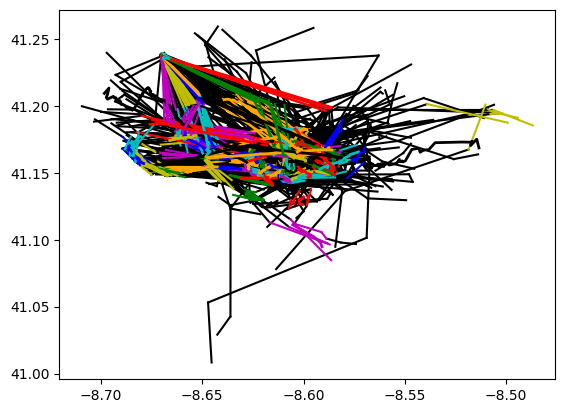

In [37]:
colors = ['k', 'g', 'r', 'c', 'm', 'y', 'b', 'orange']
clusters = out[3]
representative_trajectories = out[5]

for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        plt.plot(clusters[i][j][:,0], clusters[i][j][:,1], color=colors[i%len(colors)])


for i in range(len(representative_trajectories)):
    plt.plot(representative_trajectories[i][:,0], representative_trajectories[i][:,1], color=colors[i%len(colors)], linewidth=2)


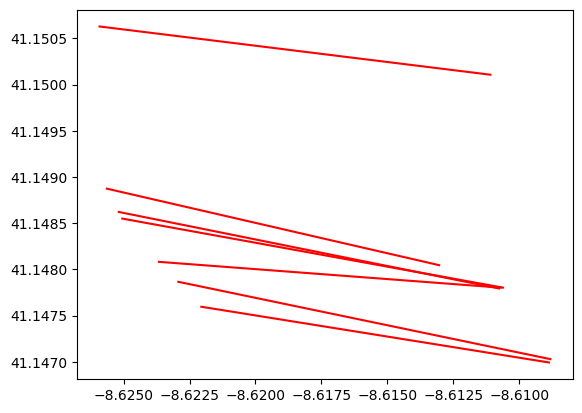

In [39]:
cluster = clusters[4]
for i in range(len(cluster)):
    plt.plot(cluster[i][:,0], cluster[i][:,1], color=colors[2])

In [35]:
print("Number of clusters:", len(clusters))

for i, cluster in enumerate(clusters):
    print("Cluster", i, ":", cluster)

Number of clusters: 110
Cluster 0 : [array([[-8.630226, 41.14521 ],
       [-8.628687, 41.152374]]), array([[-8.670852, 41.165136],
       [-8.66574 , 41.170671]]), array([[-8.612964, 41.140359],
       [-8.635131, 41.152563]]), array([[-8.649198, 41.152374],
       [-8.61597 , 41.14053 ]]), array([[-8.574678, 41.151951],
       [-8.58438 , 41.146479]]), array([[-8.598816, 41.146101],
       [-8.607996, 41.142915]]), array([[-8.659647, 41.177277],
       [-8.682615, 41.173191]]), array([[-8.682615, 41.173191],
       [-8.687268, 41.178087]]), array([[-8.615502, 41.140674],
       [-8.592993, 41.140008]]), array([[-8.592993, 41.140008],
       [-8.580168, 41.147136]]), array([[-8.580168, 41.147136],
       [-8.578224, 41.160717]]), array([[-8.57952 , 41.145948],
       [-8.593506, 41.150853]]), array([[-8.603667, 41.146578],
       [-8.603973, 41.142816]]), array([[-8.618013, 41.147505],
       [-8.622819, 41.158242]]), array([[-8.611794, 41.140557],
       [-8.611488, 41.144787]]), arr

In [38]:
start_end = tr.get_representative_trajectory(cluster)
start_end

array([[-8.50752265, 41.19392089],
       [-8.50727402, 41.19402454],
       [-8.50535624, 41.19466443],
       [-8.50438704, 41.19401512],
       [-8.50433023, 41.1940388 ],
       [-8.5019199 , 41.19408922]])